# Project: Walmart Sales Forecasting
**Phase II: Feature Engineering**

@author: Syed Shahzad Raza

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-required-dependencies" data-toc-modified-id="Import-required-dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import required dependencies</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Missing-values" data-toc-modified-id="Missing-values-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Missing values</a></span></li><li><span><a href="#Feature-Transformation" data-toc-modified-id="Feature-Transformation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Transformation</a></span></li><li><span><a href="#Indexing,-Encoding-and-Scaling" data-toc-modified-id="Indexing,-Encoding-and-Scaling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Indexing, Encoding and Scaling</a></span></li><li><span><a href="#Create-Checkpoint-for-Phase-III" data-toc-modified-id="Create-Checkpoint-for-Phase-III-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create Checkpoint for Phase III</a></span></li></ul></div>

## Import required dependencies

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, log
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession \
    .builder \
    .getOrCreate()

# import pixiedust for displaying dataframes and schemas
import pixiedust
pixiedust.optOut() # disable data sharing

# import matplotlib for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# import seaborn for data visualization
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# import pandas and numpy
import pandas as pd

Pixiedust database opened successfully


Pixiedust will not collect anonymous install statistics.


## Load Data

In [2]:
# Load data from saved file
df = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("phase_1_train_df.csv")
test_df = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("phase_1_test_df.csv")

## Missing values

In [3]:
display(df)

Store,Date,IsHoliday,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Quarter,Month,Week,Day_of_month,Day_of_year
1,2011-03-04 00:00:00,False,1,20327.61,A,151315,59.58,3.288,nan,nan,nan,nan,nan,213.8233327,7.742,2011,1,3,9,4,63
1,2011-10-07 00:00:00,False,1,20797.58,A,151315,69.31,3.285,nan,nan,nan,nan,nan,217.0453684,7.866,2011,4,10,40,7,280
1,2012-03-23 00:00:00,False,1,22107.7,A,151315,65.93,3.787,6118.56,9.48,4.97,426.72,3657.22,221.2864126,7.348,2012,1,3,12,23,83
1,2012-09-14 00:00:00,False,1,19616.22,A,151315,74.97,3.717,17212.52,7.0,18.79,1523.11,7992.72,222.5820193,6.908,2012,3,9,37,14,258
1,2012-09-28 00:00:00,False,1,18947.81,A,151315,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,222.9816579,6.908,2012,3,9,39,28,272
1,2010-02-05 00:00:00,False,2,50605.27,A,151315,42.31,2.572,nan,nan,nan,nan,nan,211.0963582,8.106,2010,1,2,5,5,36
1,2010-04-02 00:00:00,False,2,47450.5,A,151315,62.27,2.719,nan,nan,nan,nan,nan,210.8204499,7.808,2010,2,4,13,2,92
1,2012-03-23 00:00:00,False,2,44796.03,A,151315,65.93,3.787,6118.56,9.48,4.97,426.72,3657.22,221.2864126,7.348,2012,1,3,12,23,83
1,2010-07-02 00:00:00,False,3,7857.88,A,151315,80.91,2.669,nan,nan,nan,nan,nan,211.2235333,7.787,2010,3,7,26,2,183
1,2010-12-10 00:00:00,False,3,11219.78,A,151315,46.33,2.843,nan,nan,nan,nan,nan,211.4659526,7.838,2010,4,12,49,10,344


In [4]:
display(test_df)

Store,Date,IsHoliday,Dept,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Quarter,Month,Week,Day_of_month,Day_of_year
1,2013-02-01 00:00:00,False,2,A,151315,56.46,3.244,9290.91,1359.9,265.0,20657.82,972.61,224.2352903,6.525,2013,1,2,5,1,32
1,2013-03-01 00:00:00,False,2,A,151315,48.01,3.711,10610.74,261.46,2.8,25.54,2747.59,224.5645263,6.525,2013,1,3,9,1,60
1,2013-06-28 00:00:00,False,2,A,151315,83.94,3.495,4205.98,796.7,6.84,3816.78,4812.74,nan,nan,2013,2,6,26,28,179
1,2013-02-08 00:00:00,True,3,A,151315,56.67,3.417,32355.16,729.8,280.89,20426.61,4671.78,224.2350289,6.525,2013,1,2,6,8,39
1,2013-05-17 00:00:00,False,3,A,151315,69.53,3.454,16170.5,92.0,8.32,4127.24,6206.97,nan,nan,2013,2,5,20,17,137
1,2013-07-19 00:00:00,False,6,A,151315,79.26,3.556,3117.04,1060.39,199.05,1012.3,5381.72,nan,nan,2013,3,7,29,19,200
1,2013-03-15 00:00:00,False,7,A,151315,55.33,3.622,3808.13,nan,15.65,2616.6,1909.17,224.8356808,6.525,2013,1,3,11,15,74
1,2013-06-21 00:00:00,False,7,A,151315,81.35,3.479,8104.02,417.99,327.33,5182.25,3754.44,nan,nan,2013,2,6,25,21,172
1,2013-04-26 00:00:00,False,8,A,151315,59.23,3.417,2387.72,nan,98.34,516.28,1421.63,225.1701596,6.314,2013,2,4,17,26,116
1,2012-12-07 00:00:00,False,9,A,151315,64.12,3.198,6343.16,nan,270.0,2928.9,10147.9,223.6600211,6.573,2012,4,12,49,7,342


<p style="background:black;color:white">
df      - It can be seen that MarkDown columns have NA values
<br>
test_df - CPI, Unemployment and MarkDown columns have NA values
</p>

In [5]:
# Convert df data set (Spark data frame) to Pandas data frame for visualization
df_pd = df.toPandas()

In [6]:
# Convert test_df data set (Spark data frame) to Pandas data frame for visualization
test_df_pd = test_df.toPandas()

<p style="background:black;color:white">
Note: For better performance, it is suggested to take a sample of original data set while converting to Pandas Data Frame for visualization
</p>

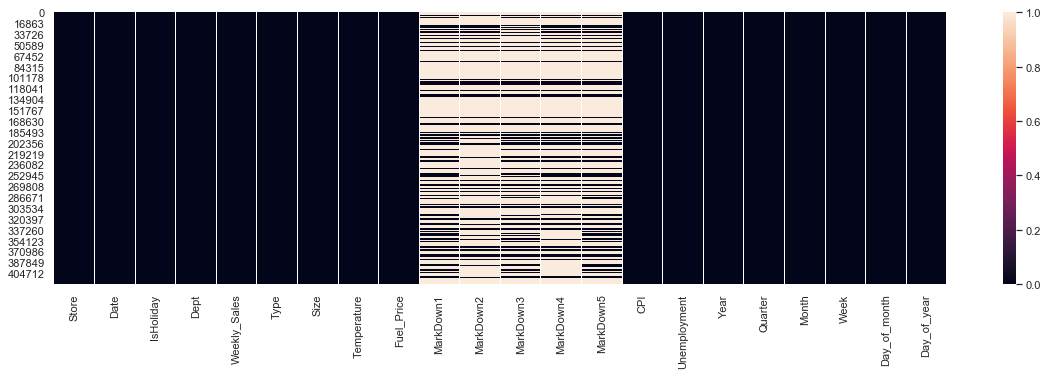

In [7]:
# Plot heat maps to visually identify missing values in training (df) and test (test_df) data sets
plt.figure(figsize=(20,5))
sns.heatmap(df_pd.isnull())

<p style="background:black;color:white">
Heat map shows that MarkDown1, MarkDown2, MarkDown3, MarkDown4 and MarkDown5 have missing values. * we will deal with missing values later
</p>

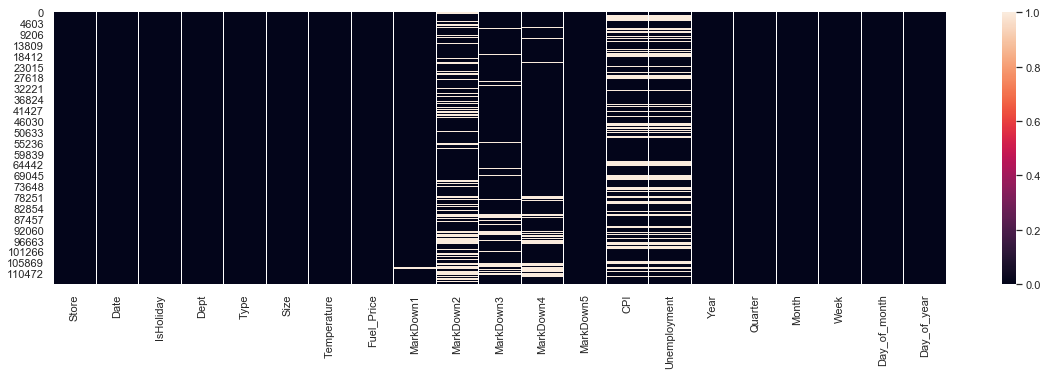

In [8]:
## heat map of test data set
plt.figure(figsize=(20,5))
sns.heatmap(test_df_pd.isnull())

<p style="background:black;color:white">
Heat map shows that MarkDown2, MarkDown3, MarkDown4, CPI and Unemployment have missing values. * we will deal with missing values later
</p>

In [9]:
# Imputing missing values using column means
imputer = Imputer(
    inputCols=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], 
    outputCols=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
)
df = imputer.setStrategy("mean").fit(df).transform(df)
test_df = imputer.setStrategy("mean").fit(test_df).transform(test_df)

In [10]:
# Look for other anomalies in data
display(df.describe())

summary,Store,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Quarter,Month,Week,Day_of_month,Day_of_year
count,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570,421570
mean,22.200545579619043,44.26031738501317,15981.25812346742,None,136727.91573878596,60.09005873283071,3.3610265270297663,7246.420195921143,3334.628621100552,1439.421384188725,3383.168256096687,4628.975079178433,171.20194682295985,7.96028869464108,2010.9685912185403,2.4827668002941388,6.4495101643855115,25.826761866356716,15.673131389804777,180.8187418459568
stddev,12.785297389903077,30.492054015785982,22711.18351916324,None,60980.58332810207,18.447931147615957,0.45851453712774926,4956.920815895335,4867.493911159962,5487.601592985901,3560.3531272636556,3573.795303769708,39.159275623012604,1.8632960384301767,0.7968760186997171,1.0713414441355695,3.243217231038047,14.151886899356166,8.75354922901775,99.21117218649094
min,1,1,-4988.94,A,34875,-2.06,2.472,0.27,-265.76,-29.1,0.22,135.16,126.064,3.879,2010,1,1,1,1,6
max,45,99,693099.36,C,219622,100.14,4.468,88646.76,104519.54,141630.61,67474.85,108519.28,227.2328068,14.313,2012,4,12,52,31,365


<p style="background:black;color:white">
Notice the minimum values are negative for some features. We will take care of these. In general, Weekly Sales and MarkDown* cannot be negative. We will replace these with zero.
</p>

In [11]:
df = df.withColumn("Weekly_Sales", when(col("Weekly_Sales") >= 0, col("Weekly_Sales")).otherwise(0))
df = df.withColumn("MarkDown1", when(col("MarkDown1") >= 0, col("MarkDown1")).otherwise(0))
df = df.withColumn("MarkDown2", when(col("MarkDown2") >= 0, col("MarkDown2")).otherwise(0))
df = df.withColumn("MarkDown3", when(col("MarkDown3") >= 0, col("MarkDown3")).otherwise(0))
df = df.withColumn("MarkDown4", when(col("MarkDown4") >= 0, col("MarkDown4")).otherwise(0))
df = df.withColumn("MarkDown5", when(col("MarkDown5") >= 0, col("MarkDown5")).otherwise(0))

<p style="background:black;color:white">
Making same changes to test_df
<br>
* note that test_df does not have column Weekly_Sales
</p>

In [12]:
test_df = test_df.withColumn("MarkDown1", when(col("MarkDown1") >= 0, col("MarkDown1")).otherwise(0))
test_df = test_df.withColumn("MarkDown2", when(col("MarkDown2") >= 0, col("MarkDown2")).otherwise(0))
test_df = test_df.withColumn("MarkDown3", when(col("MarkDown3") >= 0, col("MarkDown3")).otherwise(0))
test_df = test_df.withColumn("MarkDown4", when(col("MarkDown4") >= 0, col("MarkDown4")).otherwise(0))
test_df = test_df.withColumn("MarkDown5", when(col("MarkDown5") >= 0, col("MarkDown5")).otherwise(0))

## Feature Transformation

In [13]:
df = df.withColumn("IsHoliday", df["IsHoliday"].cast(IntegerType()))

In [14]:
test_df = test_df.withColumn("IsHoliday", test_df["IsHoliday"].cast(IntegerType()))

In [15]:
df = df.drop('Day_of_month', 'Quarter', 'Day_of_year', 'Month')

In [16]:
test_df = test_df.drop('Day_of_month', 'Quarter', 'Day_of_year', 'Month')

In [17]:
# Transforming skewed features using log transformation
skewed = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for c in skewed:
    df = df.withColumn(c, log(col(c)+1))
    test_df = test_df.withColumn(c, log(col(c)+1))
    
df = df.withColumn('Weekly_Sales', log(col('Weekly_Sales')+1))

<p style="background:black;color:white">
Recall that Year and Fuel_Price are correlated. 
<br>
We will drop Fuel_Price because Year is used to differentiate between different weeks for stores and dept
<br>
MarkDown4 and MarkDown5 are correlated with MarkDown1. We will drop MarkDown4
</p>

In [18]:
df = df.drop('MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5')

In [19]:
test_df = test_df.drop('MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5')

## Indexing, Encoding and Scaling

In [20]:
# Rename Weekly_Sales column to label
# this makes it easy to use with Linear Regression model
df = df.withColumnRenamed("Weekly_Sales","label")

In [21]:
# Drop feature Date
df = df.drop('Date')
test_df = test_df.drop('Date')

In [22]:
# Split data into train and validate sets
(train_df, validate_df) = df.randomSplit([0.8, 0.2])

In [23]:
all_vars = train_df.columns
cat_vars = ['Store', 'Dept', 'IsHoliday', 'Type']
target_value = 'label'
cont_vars = [x for x in all_vars if x not in cat_vars]
cont_vars = [x for x in cont_vars if x not in target_value]

In [24]:
indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in cat_vars ]

encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

In [25]:
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + cont_vars, outputCol="features")

In [26]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledfeatures")

<p style="background:black;color:white">
We will repeat these steps in Phase IV to create a pipeline.
</p>

## Create Checkpoint for Phase III

In [27]:
# Save data for Phase III
df.toPandas().to_csv('phase_2_train_df.csv', index=False)
test_df.toPandas().to_csv('phase_2_test_df.csv', index=False)